In [ ]:
##### MAC AND LINUX INSTALL PACKAGES #####

In [ ]:
##### WINDOWS INSTALL PACKAGES #####

In [1]:
# import the required packages
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,precision_score,recall_score

from datetime import timedelta

In [2]:
# import the data 
routes = pd.read_csv("/Users/echo/Desktop/ACRM/Team_Assignement/data/HVC_HVROUTETEMPLATE.csv",sep=";")
products = pd.read_csv("/Users/echo/Desktop/ACRM/Team_Assignement/data/HVC_AR0.csv",sep=";")
customers = pd.read_csv("/Users/echo/Desktop/ACRM/Team_Assignement/data/HVC_SO0.csv",sep=";")
visitdetails = pd.read_csv("/Users/echo/Desktop/ACRM/Team_Assignement/data/HVC_VISITRESULTDETAILS.csv",sep=";")
visits = pd.read_csv("/Users/echo/Desktop/ACRM/Team_Assignement/data/HVC_HVVISITRESULT.csv",sep=";")

# 0. Introduction to the case

This cross-sell case is about a company in the food industry. Sales representatives drive around to visit customers and try to convince them to buy more or new products. Based on the profitability of the customer, sales representatives decide whether they will add them to their route or not. 

The goal of this case is to construct a model that is able to predict which product a customer will buy next. 

# 1. Data Exploration

## 1.1. Customers

Inspect the shape and the first few observations of the customers dataframe

In [3]:
# inspect shape
customers.shape

(5709, 6)

In [4]:
# check first observations of customers dataset
customers.head()

,SO0_NRID,HVROUTETEMPLATE_NRID,CUST_TYPE,POSTCODE,LANGUAGE,SEASON_TYPE
0,721104.0,219020601.0,Private,3930,nl-BE,All time
1,721110.0,219020601.0,Private,3930,nl-BE,All time
2,721121.0,219020601.0,Private,3930,nl-BE,All time
3,721126.0,219020601.0,Private,3930,nl-BE,All time
4,721131.0,219020601.0,Private,3930,nl-BE,All time


The table above contains several pieces of information about customers, i.e. on which route they are located (RouteID), the type of customer they are (CustomerType), the ZIP code of the area they are located in (ZIP), and the season in which they are customers (SeasonType). 

Based on the table above, we may suspect that the variable 'CustomerID' represents a unique ID for each customer. To make sure that this is the case, we have to check whether 'CustomerID' is unique. 

In [6]:
# inspect if CustomerID is unique in customers dataset
customers["SO0_NRID"].is_unique

True

Furthermore, to gain a better understanding of the variables in the table, we check out the different categories (and the frequency with which the occur) of the variables 'CustomerType' and 'SeasonType'

In [7]:
# inspect SeasonType categories and frequencies
customers["SEASON_TYPE"].value_counts()

All time     5554
Summer        150
Christmas       3
Winter          1
Name: SEASON_TYPE, dtype: int64

In [8]:
# inspect CustomerType categories and frequencies
customers["CUST_TYPE"].value_counts()

Private     5579
Horeca        97
Catering      33
Name: CUST_TYPE, dtype: int64

## 1.2. Products

Inspect the shape and the first few observations of the products dataframe

In [9]:
# inspect shape
products.shape

(317, 5)

In [10]:
# check first observations of products dataset
products.head()

,AR0_NRID,DESCRIPTION,CATEGORY,FAMILY,PRICE
0,20742288286838,Dessert Caramel/14,Verkoopsartikel,Cups,10.9
1,20413488326838,Penalty/16,Verkoopsartikel,Hand Ice,6.5
2,21515648414638,Kriekentaart,Verkoopsartikel,Coffee,7.9
3,20296288686840,Expo met zachte wafel/12,Verkoopsartikel,Individual Dessert,7.3
4,21844652504048,Paaseitjes,Verkoopsartikel,Individual Dessert,7.5


Again, we need to verify whether 'ProductID' is unique

In [11]:
# check if ProductID is unique in table
products["AR0_NRID"].is_unique

True

We also would like to know the number of different categories (and frequencies) for the variables 'Category' and 'Family'. 

In [12]:
# inspect Category categories and frequencies
products["CATEGORY"].value_counts()

Verkoopsartikel    287
Kortingsbon         28
POS                  2
Name: CATEGORY, dtype: int64

In [13]:
# inspect Family categories and frequencies
products["FAMILY"].value_counts()

Scoop Ice             64
Hand Ice              46
Cups                  37
Meals                 36
Coffee                23
Ice Cakes             23
Individual Dessert    22
Garniture             12
Assortments            8
BIG                    2
POS inside             2
Name: FAMILY, dtype: int64

For the variable 'Family', represent this visually by means of a barplot. Thus, the x-axis should represent the the product families and the y-axis should display the number of products in each product family. 

In [14]:
# inspect number of products per product families

# get number of products per family
family_counts = pd.DataFrame(products["FAMILY"].value_counts().reset_index())
family_counts

,index,FAMILY
0,Scoop Ice,64
1,Hand Ice,46
2,Cups,37
3,Meals,36
4,Coffee,23
5,Ice Cakes,23
6,Individual Dessert,22
7,Garniture,12
8,Assortments,8
9,BIG,2


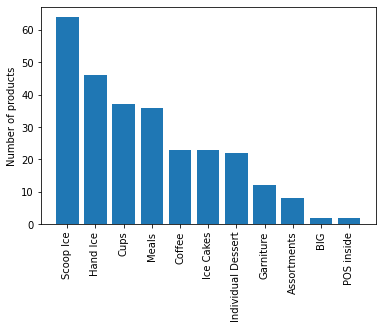

In [15]:
# rename columns
family_counts.columns = ["FAMILY", "num_products"]
# plot
plt.bar(family_counts["FAMILY"], family_counts["num_products"])
plt.xticks(range(len(family_counts)), family_counts["FAMILY"], rotation=90)
plt.ylabel("Number of products")
plt.show()

## 1.3. Visits

Inspect the shape and the first few observations of the products dataframe

In [16]:
# inspect shape
visits.shape

(240415, 8)

In [17]:
# inspect first observations of visits dataset
visits.head()

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM
0,55681456,719952,23186288605042,2,"12:20:01,000000000",2019-05-06,16.9,cash
1,55681507,1453609,19946584592834,2,"12:13:50,000000000",2019-05-06,7.4,cash
2,55681509,1453614,19946584592834,2,"12:14:08,000000000",2019-05-06,18.9,cash
3,55681512,1453602,19946584592834,1,"12:16:04,000000000",2019-05-06,0.0,NaN
4,55674074,1252497,18934048107254,2,"10:41:09,000000000",2019-05-06,34.9,tbp


This table contains one row per visit. For each visit, it shows which customer (CustomerID) has been visited by which sales representative (SalesRepresentativeID) on what day (VisitDate). Furthermore, it also shows the outcome of the visit, the amount that was purchased and the payment term of the purchase.

First of all, we have to convert 'VisitDate' to pandas Datetime type (hint: use Google to figure out the correct format) 

In [18]:
# convert VisitDate of visits DataFrame to pandas Datetime type: 12:20:01,000000000
visits["VISITDATE"] = pd.to_datetime(visits["VISITDATE"], format="%H:%M:%S,000000000")

visits["DATEONLY"] = pd.to_datetime(visits["DATEONLY"], format="%Y-%m-%d")

We also need to check whether 'VisitID' and 'CustomerID' are unique. 

In [21]:
# check if VisitID is unique
visits["HVVISITRESULT_NRID"].is_unique

True

In [20]:
# check if CustomerID is unique
visits["SO0_NRID"].is_unique

False

As 'VisitID' is unique and 'CustomerID' is not, this means that a customer can be visited multiple times. However, each visit is identified by a unique ID. 

Finally, let's check the different possible outcomes and the proportion with which they occur. 

In [23]:
# inspect the proportion of outcomes of the visits
visits["HVOUTCOME_NRID"].value_counts(normalize=True)*100

0    38.997151
2    32.830730
1    28.172119
Name: HVOUTCOME_NRID, dtype: float64

## 1.4. VisitDetails

Inspect the shape and the first few observations of the visitdetails dataframe

In [24]:
# inspect shape
visitdetails.shape

(126778, 4)

In [25]:
# inspect visitdetails
visitdetails.head()

,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,HVVISITRESULT_NRID
0,56055671,17545160268040,1.0,56055665.0
1,56055672,23699,2.0,56055665.0
2,56055675,23721,1.0,56055674.0
3,56010656,23714,1.0,56010655.0
4,56009821,23716,1.0,56009820.0


Check whether 'VisitDetailID', 'ProductID' and 'VisitID' are unique. 

In [26]:
# check if VisitDetailID is unique
visitdetails["VISITRESULTDETAILS_NRID"].is_unique

True

In [27]:
# check if ProductID is unique
visitdetails["AR0_NRID"].is_unique

False

In [28]:
# check if VisitID is unique
visitdetails["HVVISITRESULT_NRID"].is_unique

False

As 'VisitDetailID' is unique and the other two variables are not, this means that the dataframe visitdetails contains 1 row per VisitDetail. Each VisitDetail is linked to a visit (VisitID) and a product (ProductID) but each visit can contain multiple VisitDetails. Similarly, products can be linked to several Visitdetails. 

## 1.5. Routes

Inspect the shape and the first few observations of the routes dataframe

In [29]:
# inspect shape
routes.shape

(39, 4)

In [30]:
# inspect first observations of routes
routes.head()

,HVROUTETEMPLATE_NRID,REGION,WEEKORDER,HVDAYOFWEEK_NRID
0,70671404.0,C04,1.0,1.0
1,219018687.0,C04,1.0,2.0
2,219019324.0,C04,1.0,3.0
3,219019962.0,C04,1.0,4.0
4,219020601.0,C04,1.0,5.0


# 2. Determine ERD

An Entity Relationship Diagram (ERD) represents the entities (in this case, the different dataframes) and the relationshops among these entities. 

-> It visualizes how the different dataframes are connected with eachother and how the most important variables are related to one another. 

Gaining such insights in your data is important. For example, when merging different dataframes. 

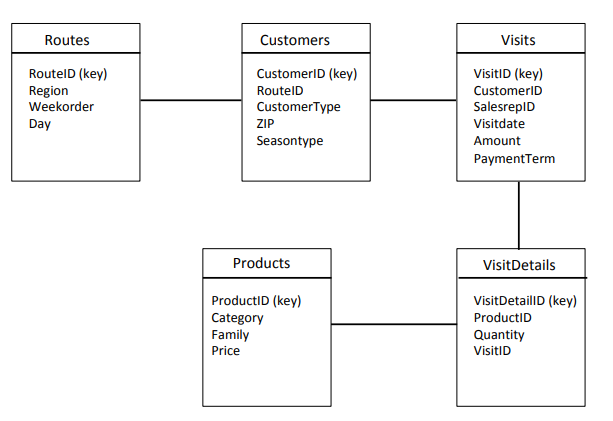

## 2.1. Products and Visitdetails
 PRODUCT 1,1 ------* VisitDetails
 In visitderails => visitdetails is unique, but one visitdetails => multiple product ID
 

In [28]:
visitdetails.head()

,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,HVVISITRESULT_NRID
0,56055671,17545160268040,1.0,56055665.0
1,56055672,23699,2.0,56055665.0
2,56055675,23721,1.0,56055674.0
3,56010656,23714,1.0,56010655.0
4,56009821,23716,1.0,56009820.0


In [30]:
# The Products and VisitDetails dataset can be linked by the ProductID

# check if ProductID is unique in products
print("ProductID unique in products? %s" %products["AR0_NRID"].is_unique)

# check if ProductID is unique in visitdetails
print("ProductID unique in visitdetails? %s" %visitdetails["AR0_NRID"].is_unique)

# check if all products from product table are accounted for in visitdetails table
print("all ProductIDs from products accounted for in visitdetails? %s" %all(products["AR0_NRID"].isin(visitdetails["AR0_NRID"])))

# check if all products from visitdetails table are accounted for in products table
print("all ProductIDs from visitdetails accounted for in products? %s" %all(visitdetails["AR0_NRID"].isin(products["AR0_NRID"])))


ProductID unique in products? True
ProductID unique in visitdetails? False
all ProductIDs from products accounted for in visitdetails? True
all ProductIDs from visitdetails accounted for in products? True


In [ ]:
# get minimum, maxium and average number of visitdetails per product
visitdetails_per_products_stats = visitdetails.groupby("ProductID")["VisitDetailID"].count().reset_index()
visitdetails_per_products_stats.columns = ["ProductID", "num_visitdetails"]
print("minimum number of visitdetails per product: %s" %min(visitdetails_per_products_stats["num_visitdetails"]))
print("maximum number of visitdetails per product: %s" %max(visitdetails_per_products_stats["num_visitdetails"]))
print("average number of visitdetails per product: %s" %np.mean(visitdetails_per_products_stats["num_visitdetails"]))

In [ ]:
# every product has 1 to N visitdetails
# every visitdetail is linked to one product 

## 2.2. Visitdetails and Visits

Visit 1,1-------* VisitDetails
=> 1 visit has 1 to N visitdetails (In visitdetails==> Visitdetail_id is unique, Visit_ID is not unique)
=>every visitdetail correspond 1 Visit 

In [33]:
visitdetails.head()

,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,HVVISITRESULT_NRID
0,56055671,17545160268040,1.0,56055665.0
1,56055672,23699,2.0,56055665.0
2,56055675,23721,1.0,56055674.0
3,56010656,23714,1.0,56010655.0
4,56009821,23716,1.0,56009820.0


In [34]:
# The Visits and VisitDetails dataset can be linked by the VisitID

# check if VisitID is unique in visits
print("VisitID unique in visits? %s" %visits["HVVISITRESULT_NRID"].is_unique)

# check if VisitID is unique in visitdetails
print("VisitID unique in visitdetails? %s" %visitdetails["HVVISITRESULT_NRID"].is_unique)

# check if all visits from visits table are accounted for in visitdetails table
print("all VisitIDs from visits accounted for in visitdetails? %s" %all(visits["HVVISITRESULT_NRID"].isin(visitdetails["HVVISITRESULT_NRID"])))

# check if all products from visitdetails table are accounted for in products table
print("all VisitIDs from visitdetails accounted for in visits? %s" %all(visitdetails["HVVISITRESULT_NRID"].isin(visits["HVVISITRESULT_NRID"])))


VisitID unique in visits? True
VisitID unique in visitdetails? False
all VisitIDs from visits accounted for in visitdetails? False
all VisitIDs from visitdetails accounted for in visits? True


In [ ]:
# get minimum, maxium and average number of visitdetails per visit
visitdetails_per_visit_stats = visitdetails.groupby("VisitID")["VisitDetailID"].count().reset_index()
visitdetails_per_visit_stats.columns = ["VisitID", "num_visitdetails"]
print("minimum number of visitdetails per visit: %s" %min(visitdetails_per_visit_stats["num_visitdetails"]))
print("maximum number of visitdetails per visit: %s" %max(visitdetails_per_visit_stats["num_visitdetails"]))
print("average number of visitdetails per visit: %s" %np.mean(visitdetails_per_visit_stats["num_visitdetails"]))

In [ ]:
# every visit has 0 to N visitdetails
# every visitdetail is linked to one visit
#有的visit没有details

## 2.3. Visits and Customers

Customer 1,1-------* VisitDetails
In visits, visit_id is unique, but clien_id is not unique( because 1 customer correspond to 1 and N visites)

In [36]:
visits.head()

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM
0,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash
1,55681507,1453609,19946584592834,2,1900-01-01 12:13:50,2019-05-06,7.4,cash
2,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash
3,55681512,1453602,19946584592834,1,1900-01-01 12:16:04,2019-05-06,0.0,NaN
4,55674074,1252497,18934048107254,2,1900-01-01 10:41:09,2019-05-06,34.9,tbp


In [39]:
print("CustomerID unique in Customers? %s" %customers['SO0_NRID'].is_unique)
print("CustomerID unique in Visits? %s" %visits['SO0_NRID'].is_unique)
print("All customerID from customer accounted for in visit? %s"%all(customers['SO0_NRID'].isin(visits['SO0_NRID'])))
print("All customerID from visits accounted for in customer? %s"%all(visits['SO0_NRID'].isin(customers['SO0_NRID'])))

CustomerID unique in Customers? True
CustomerID unique in Visits? False
All customerID from customer accounted for in visit? False
All customerID from visits accounted for in customer? True


有的客户没有visit记录

## 2.4. Customers and Routes
Customers *----1.1 Route 

In [42]:
print("RouteID unique in Customers? %s" %customers['HVROUTETEMPLATE_NRID'].is_unique)
print("RouteID unique in RouteID? %s" %routes['HVROUTETEMPLATE_NRID'].is_unique)
print("All routeID from routes accounted for in customer? %s"%all(routes['HVROUTETEMPLATE_NRID'].isin(customers['HVROUTETEMPLATE_NRID'])))
print("All routeID from customers accounted for in routes? %s"%all(customers['HVROUTETEMPLATE_NRID'].isin(routes['HVROUTETEMPLATE_NRID'])))

RouteID unique in Customers? False
RouteID unique in RouteID? True
All routeID from routes accounted for in customer? True
All routeID from customers accounted for in routes? True


# 3. Time Window

To be able to design our time window, we first have to check for which period of time data is available

This window of time needs to be split in the independent period, the gap, and the dependent period. 

Construct a time window, taking into consideration the following aspects: 

    (1) we want a dependent period of 1 month (we choose 1 month as this is the time that the sales representatives need to visit all the clients) 
    (2) the gap should equal 1 day 
    
Hint: It might be useful to draw the time window first, before you start coding. 

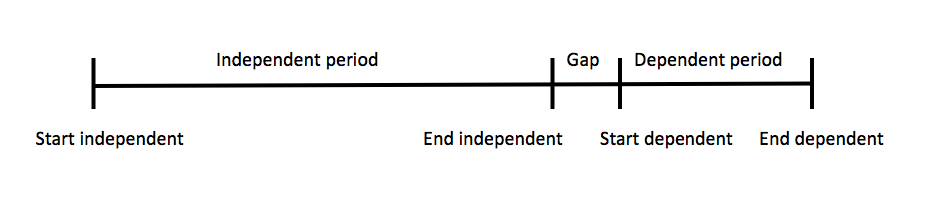

In [31]:
# END_DEPENDENT :latest Visit date 
end_dependent=visits['DATEONLY'].max()
start_dependent=end_dependent-timedelta(days=30)
end_independent=start_dependent-timedelta(days=1)

# 4. Data Preparation

## 4.1. Customer Selection

When computing the dependent and independent variables (features), we can only use data from the respective relevant time periods. 

In other words, the predictive features should be computed on data that was available in the independent period. The dependent variable (in our case, which product family will be bought next) has to be computed based on data from the dependent period. 


In [32]:
visits.head()

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM
0,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash
1,55681507,1453609,19946584592834,2,1900-01-01 12:13:50,2019-05-06,7.4,cash
2,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash
3,55681512,1453602,19946584592834,1,1900-01-01 12:16:04,2019-05-06,0.0,NaN
4,55674074,1252497,18934048107254,2,1900-01-01 10:41:09,2019-05-06,34.9,tbp


In [33]:
# separate independent from dependent visits
visits_indep = visits[(visits["DATEONLY"] < end_independent)&(visits["AMOUNT"]>0)]
visits_dep = visits[(visits["DATEONLY"] > start_dependent) & (visits["DATEONLY"] < end_dependent)&(visits["AMOUNT"]>0)]

## 4.2. Features

### 4.2.1. RFM of Customers 

The RFM variables represent the recency, frequency and monetary values of actual purchases. Hence, we start by selecting the visits in the independent period that led to a purchase (i.e., Amount > 0).

The RFM variables should be computed by customer. Therefore, we need to group the visits by customerID. 

In [34]:
visits_indep.head()

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM
0,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash
1,55681507,1453609,19946584592834,2,1900-01-01 12:13:50,2019-05-06,7.4,cash
2,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash
4,55674074,1252497,18934048107254,2,1900-01-01 10:41:09,2019-05-06,34.9,tbp
17,55714733,1251884,18934048107254,2,1900-01-01 21:40:35,2019-05-06,8.5,cash


In [35]:
# group data by customer
recency = visits_indep.groupby("SO0_NRID").agg({'DATEONLY':max}).reset_index()

In [36]:
recency.head()

,SO0_NRID,DATEONLY
0,687782,2020-08-02
1,718230,2020-10-17
2,718236,2020-09-05
3,718247,2020-08-22
4,718257,2020-10-31


Calculate the recency, i.e. the number of days since the last purchase in the independent period

In [37]:
recency['RECENCY']=recency['DATEONLY'].apply(lambda x: (end_independent-x).days)
recency=recency.drop('DATEONLY',axis=1)
recency.head()

,SO0_NRID,RECENCY
0,687782,117
1,718230,41
2,718236,83
3,718247,97
4,718257,27


Calculate the frequency, i.e. the number of purchases in the independent period

In [38]:
visits_indep['HVOUTCOME_NRID'].value_counts()

2    73283
Name: HVOUTCOME_NRID, dtype: int64

In [39]:
frequency=visits_indep.groupby("SO0_NRID").agg({'HVVISITRESULT_NRID':'count'}).reset_index()
frequency.columns=['SO0_NRID','FREQUENCY']
frequency.head()

,SO0_NRID,FREQUENCY
0,687782,15
1,718230,20
2,718236,14
3,718247,7
4,718257,30


Calculate the monetary value, i.e. the total amount spent by a customer in the independent period

In [40]:
monetary=visits_indep.groupby("SO0_NRID").agg({'AMOUNT':['sum','mean']}).reset_index()
monetary.columns=['SO0_NRID','TOTAL_AMOUNT','AVG_AMOUNT']
monetary.head()

,SO0_NRID,TOTAL_AMOUNT,AVG_AMOUNT
0,687782,167.0,11.133333
1,718230,204.9,10.245000
2,718236,127.5,9.107143
3,718247,42.6,6.085714
4,718257,260.3,8.676667


Finally, we need to merge the RFM variables into one dataframe

In [41]:
customer_rfm=pd.merge(recency,frequency,how='inner',on='SO0_NRID').merge(monetary,on='SO0_NRID')
customer_rfm.head()

,SO0_NRID,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT
0,687782,117,15,167.0,11.133333
1,718230,41,20,204.9,10.245000
2,718236,83,14,127.5,9.107143
3,718247,97,7,42.6,6.085714
4,718257,27,30,260.3,8.676667


### 4.2.2. Product History

In addition to the RFM variables, we would also like to use the following variables as predictive features: 

    (1) The number of products bought in each product family during the independent period 
    (2) The last product family bought in the independent period 

In [42]:
## visits_indep：
visits_indep.head(5)

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM
0,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash
1,55681507,1453609,19946584592834,2,1900-01-01 12:13:50,2019-05-06,7.4,cash
2,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash
4,55674074,1252497,18934048107254,2,1900-01-01 10:41:09,2019-05-06,34.9,tbp
17,55714733,1251884,18934048107254,2,1900-01-01 21:40:35,2019-05-06,8.5,cash


In [43]:
visitdetails.head()

,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,HVVISITRESULT_NRID
0,56055671,17545160268040,1.0,56055665.0
1,56055672,23699,2.0,56055665.0
2,56055675,23721,1.0,56055674.0
3,56010656,23714,1.0,56010655.0
4,56009821,23716,1.0,56009820.0


In [97]:
products.head()

,AR0_NRID,DESCRIPTION,CATEGORY,FAMILY,PRICE
0,20742288286838,Dessert Caramel/14,Verkoopsartikel,Cups,10.9
1,20413488326838,Penalty/16,Verkoopsartikel,Hand Ice,6.5
2,21515648414638,Kriekentaart,Verkoopsartikel,Coffee,7.9
3,20296288686840,Expo met zachte wafel/12,Verkoopsartikel,Individual Dessert,7.3
4,21844652504048,Paaseitjes,Verkoopsartikel,Individual Dessert,7.5


In [44]:
# left merge: visits_indep, visitdetails,products ===> get SO0_NRID,AR0_NRID,FAMILY
visit_prod_ind=pd.merge(visits_indep,visitdetails,how='left',on='HVVISITRESULT_NRID').merge(products,how='left',on='AR0_NRID')
visit_prod_ind.head()

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,DESCRIPTION,CATEGORY,FAMILY,PRICE
0,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash,55681457,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
1,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash,55681458,17453864687246,1.0,Cornets d'Amour BrÃ©s 16+4,Verkoopsartikel,Hand Ice,9.5
2,55681507,1453609,19946584592834,2,1900-01-01 12:13:50,2019-05-06,7.4,cash,55681508,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
3,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash,55681510,21744156237250,2.0,Donuts Deluxe,Verkoopsartikel,Coffee,5.2
4,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash,55681511,23734,1.0,Maxi Vanille/24,Verkoopsartikel,Hand Ice,8.5


In [45]:
cust_product=visit_prod_ind.groupby(['SO0_NRID','FAMILY']).agg({'AR0_NRID':'count'}).reset_index()
cust_product.head()

,SO0_NRID,FAMILY,AR0_NRID
0,687782,Assortments,3
1,687782,Coffee,1
2,687782,Garniture,1
3,687782,Hand Ice,7
4,687782,Scoop Ice,10


In [46]:
cust_pro_amount=cust_product.pivot_table(index='SO0_NRID',columns='FAMILY',values='AR0_NRID',fill_value=0).reset_index()
cust_pro_amount.head()

FAMILY,SO0_NRID,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,Ice Cakes,Individual Dessert,Meals,POS inside,Scoop Ice
0,687782,3,0,1,0,1,7,0,0,0,0,10
1,718230,0,0,2,7,0,7,2,6,1,0,1
2,718236,0,0,0,0,0,10,1,1,0,0,4
3,718247,1,0,0,0,0,1,0,0,0,0,5
4,718257,1,0,0,1,0,29,0,1,0,0,0


The information we need to compute these variables can be found in the visitdetails dataframe. In other words, we need to extract the information related to the visits in the independent period from the visitdetails dataframe.

In [47]:
# The last product family bought in the independent period 
# last visit_date
max_visit_date=visits_indep.groupby('SO0_NRID').agg({'DATEONLY':max}).reset_index()
last_product=pd.merge(visits_indep,max_visit_date,how='inner',on=['SO0_NRID','DATEONLY']).merge(visitdetails,how='left',on='HVVISITRESULT_NRID').merge(products,how='left',on='AR0_NRID')
last_product=last_product[['SO0_NRID','FAMILY']].drop_duplicates()
last_product.columns=['SO0_NRID','LAST_FAMILY']
last_product

,SO0_NRID,LAST_FAMILY
0,875096,Scoop Ice
2,22594788446036,Scoop Ice
3,22594788446036,Ice Cakes
4,22594788446036,Hand Ice
5,1253653,Ice Cakes
...,...,...
7947,56961121,Ice Cakes
7948,56961121,Meals
7949,56961121,Coffee
7950,56961121,Individual Dessert


In [48]:
ind_table=pd.merge(customer_rfm,cust_pro_amount,how='left',on='SO0_NRID').merge(last_product,on='SO0_NRID')
ind_table.head()

,SO0_NRID,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,Ice Cakes,Individual Dessert,Meals,POS inside,Scoop Ice,LAST_FAMILY
0,687782,117,15,167.0,11.133333,3,0,1,0,1,7,0,0,0,0,10,Scoop Ice
1,718230,41,20,204.9,10.245000,0,0,2,7,0,7,2,6,1,0,1,Cups
2,718236,83,14,127.5,9.107143,0,0,0,0,0,10,1,1,0,0,4,Hand Ice
3,718247,97,7,42.6,6.085714,1,0,0,0,0,1,0,0,0,0,5,Scoop Ice
4,718257,27,30,260.3,8.676667,1,0,0,1,0,29,0,1,0,0,0,Hand Ice


## 4.3. Dependent Variable

As we want to predict which product (or product family: see later) a customer is most likely to buy next, our dependent variable will be the first product (or product family) that a customer has bought in the dependent period. 

The information we need can be found in the visitdetails dataframe.

In [49]:
visitdetails.head()

,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,HVVISITRESULT_NRID
0,56055671,17545160268040,1.0,56055665.0
1,56055672,23699,2.0,56055665.0
2,56055675,23721,1.0,56055674.0
3,56010656,23714,1.0,56010655.0
4,56009821,23716,1.0,56009820.0


In [50]:
prod_ind=pd.merge(visits_indep,visitdetails,on='HVVISITRESULT_NRID',how='left').merge(products,on='AR0_NRID',how='left')
prod_ind.head()

,HVVISITRESULT_NRID,SO0_NRID,AM0_NRID,HVOUTCOME_NRID,VISITDATE,DATEONLY,AMOUNT,PAYMENTTERM,VISITRESULTDETAILS_NRID,AR0_NRID,QUANTITY,DESCRIPTION,CATEGORY,FAMILY,PRICE
0,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash,55681457,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
1,55681456,719952,23186288605042,2,1900-01-01 12:20:01,2019-05-06,16.9,cash,55681458,17453864687246,1.0,Cornets d'Amour BrÃ©s 16+4,Verkoopsartikel,Hand Ice,9.5
2,55681507,1453609,19946584592834,2,1900-01-01 12:13:50,2019-05-06,7.4,cash,55681508,23678,1.0,"2,5 L.Vanille",Verkoopsartikel,Scoop Ice,7.4
3,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash,55681510,21744156237250,2.0,Donuts Deluxe,Verkoopsartikel,Coffee,5.2
4,55681509,1453614,19946584592834,2,1900-01-01 12:14:08,2019-05-06,18.9,cash,55681511,23734,1.0,Maxi Vanille/24,Verkoopsartikel,Hand Ice,8.5


get the family of first product for the first order: 

In [51]:
first_transaction=prod_ind.groupby('SO0_NRID').agg({'DATEONLY':min}).reset_index()
first_product=pd.merge(first_transaction,prod_ind,on=['SO0_NRID','DATEONLY'])[['SO0_NRID','FAMILY']]
first_product=first_product.groupby('SO0_NRID').head(1)
first_product.columns=['SO0_NRID','FIRST_FAMILY']
first_product.head()

,SO0_NRID,FIRST_FAMILY
0,687782,Hand Ice
3,718230,Individual Dessert
5,718236,Hand Ice
6,718247,Scoop Ice
7,718257,Hand Ice


Visually inspect the distribution of first bought products in the dependent period. 

So the x-axis should contain the different products, whereas the y-axis will represent the number of times a product was bought as first product in the dependent period. 

In [54]:
first_product_dist=first_product.groupby('FIRST_FAMILY').agg({'SO0_NRID':'count'}).reset_index()
first_product_dist.columns=['FAMILY','NUMBER']
first_product_dist.head()

,FAMILY,NUMBER
0,Assortments,308
1,BIG,60
2,Coffee,158
3,Cups,507
4,Garniture,59


In [55]:
len(first_product_dist['NUMBER'])

11

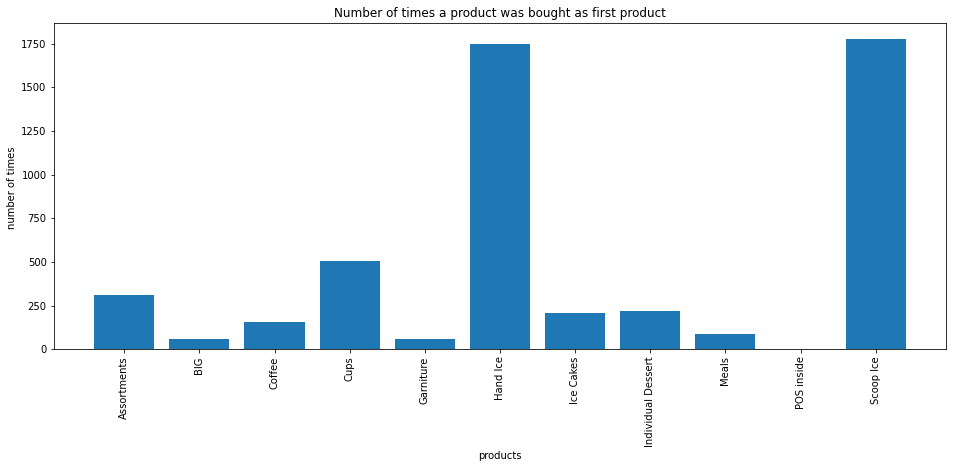

In [56]:
plt.figure(figsize=(16,6))
plt.bar(range(len(first_product_dist['NUMBER'])),first_product_dist['NUMBER'])
plt.xticks(range(len(first_product_dist['NUMBER'])),first_product_dist['FAMILY'],rotation=90)
plt.xlabel('products')
plt.ylabel('number of times ')
plt.title('Number of times a product was bought as first product')
plt.show()

# 5.  Basetable

To create the final basetable, we still need to complete the following steps: 

    (1) Merge the necessary datasets 
    (2) Split the data into training, validation and test set (60-20-20)
    (3) Seperate the sets into the features on the one hand, and the dependent variable on the other hand
    (4) Standardize the numeric features 
    (5) Create dummy variables for categorical features such as 'last_family_indep'
    (6) Encode the categorical dependent variable (first_product_dep_thresh) into numbers

## 5.1. Merge datasets

In [57]:
# basetable :first_product
basetable=pd.merge(ind_table,first_product,how='inner',on='SO0_NRID')
basetable=basetable.drop('SO0_NRID',axis=1)
basetable.head()

,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,Ice Cakes,Individual Dessert,Meals,POS inside,Scoop Ice,LAST_FAMILY,FIRST_FAMILY
0,117,15,167.0,11.133333,3,0,1,0,1,7,0,0,0,0,10,Scoop Ice,Hand Ice
1,41,20,204.9,10.245000,0,0,2,7,0,7,2,6,1,0,1,Cups,Individual Dessert
2,83,14,127.5,9.107143,0,0,0,0,0,10,1,1,0,0,4,Hand Ice,Hand Ice
3,97,7,42.6,6.085714,1,0,0,0,0,1,0,0,0,0,5,Scoop Ice,Scoop Ice
4,27,30,260.3,8.676667,1,0,0,1,0,29,0,1,0,0,0,Hand Ice,Hand Ice


## 5.2. Train - Validation -Test split
#### Train(60%) - Validation (0.2) - test set (0.2)

In [58]:
# split data into training, validation and test set (60-20-20)
train,val_test=train_test_split(basetable,test_size=0.4,random_state=21)
val,test=train_test_split(val_test,test_size=0.5,random_state=57)



## 5.3. Separate the dependent variable and the features (optional)

### Y's: FIRST_FAMILY   X's: basetable.drop['FIRST_FAMILY','']

In [59]:
train.head()

,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,Ice Cakes,Individual Dessert,Meals,POS inside,Scoop Ice,LAST_FAMILY,FIRST_FAMILY
6106,599,3,29.8,9.933333,0,0,1,0,0,2,0,0,1,0,0,Hand Ice,Coffee
3385,90,9,62.5,6.944444,0,0,0,3,0,2,0,0,0,0,5,Scoop Ice,Scoop Ice
600,172,10,174.0,17.400000,0,0,4,0,0,2,3,1,12,0,0,Hand Ice,Coffee
1287,10,33,589.2,17.854545,6,1,1,37,4,9,7,0,0,0,14,Hand Ice,Cups
2631,138,6,71.8,11.966667,1,0,0,0,0,1,1,0,1,0,4,Hand Ice,Assortments


In [60]:
X_train=train.drop('FIRST_FAMILY',axis=1)
Y_train=train['FIRST_FAMILY']

X_val=val.drop('FIRST_FAMILY',axis=1)
Y_val=val['FIRST_FAMILY']

X_test=test.drop('FIRST_FAMILY',axis=1)
Y_test=test['FIRST_FAMILY']

## 5.4. Standardization

In [61]:
# standardize the numeric features: RECENCY FREQUENCY TOTAL_AMOUNT AVG_AMOUNT
from sklearn.preprocessing import MinMaxScaler
scalar=MinMaxScaler()
scalar.fit(X_train[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']])
X_train[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']]=scalar.transform(X_train[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']])
X_test[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']]=scalar.transform(X_test[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']])
X_val[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']]=scalar.transform(X_val[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']])


In [62]:
X_train[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']].describe()

,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT
count,3973.000000,3973.000000,3973.000000,3973.000000
mean,0.125571,0.131867,0.014846,0.026387
std,0.171500,0.107913,0.034379,0.038575
min,0.000000,0.000000,0.000000,0.000000
25%,0.021834,0.051020,0.004940,0.015252
50%,0.065502,0.112245,0.009472,0.019484
75%,0.155750,0.193878,0.017022,0.025959
max,1.000000,1.000000,1.000000,1.000000


## 5.5. Dummy variables

In [63]:
# create dummy variables for categorical features :X_train['LAST_FAMILY']
X_train=pd.get_dummies(X_train)
X_test=pd.get_dummies(X_test)
X_val=pd.get_dummies(X_val)
X_val.head()

,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,...,LAST_FAMILY_Assortments,LAST_FAMILY_BIG,LAST_FAMILY_Coffee,LAST_FAMILY_Cups,LAST_FAMILY_Garniture,LAST_FAMILY_Hand Ice,LAST_FAMILY_Ice Cakes,LAST_FAMILY_Individual Dessert,LAST_FAMILY_Meals,LAST_FAMILY_Scoop Ice
4675,0.104803,0.010204,0.002526,0.031168,0,0,0,4,0,0,...,0,0,0,1,0,0,0,0,0,0
5202,0.065502,0.142857,0.019182,0.031104,0,0,0,5,0,14,...,0,0,0,0,0,1,0,0,0,0
2758,0.016012,0.081633,0.008106,0.021662,0,0,0,1,0,12,...,0,0,0,0,0,1,0,0,0,0
5640,0.176128,0.040816,0.005953,0.029032,0,0,0,3,0,7,...,0,0,0,1,0,0,0,0,0,0
3251,0.033479,0.112245,0.009324,0.018527,0,0,0,1,0,5,...,0,0,0,0,0,1,0,0,0,0


Note: Why is it important to use reindex after applying get_dummies on the validation and test dataset? 

When you apply the get_dummies() on the validation and test dataset, you will lose the non-existing levels (i.e., the categories that are present in the training dataset but perhaps not in the validation and/or test dataset) of the train dataset. However, it is important to feed your model with the same columns of the train dataset. Therefore it is important to use the reindex function.

In [64]:
#index:按照X—train的columns => 如果索引在原数据中没有匹配，则以0（而不是NaN)填充。
X_test=X_test.reindex(columns=X_train.columns,fill_value=0)
X_val=X_val.reindex(columns=X_train.columns,fill_value=0)
X_val.head()

,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,...,LAST_FAMILY_BIG,LAST_FAMILY_Coffee,LAST_FAMILY_Cups,LAST_FAMILY_Garniture,LAST_FAMILY_Hand Ice,LAST_FAMILY_Ice Cakes,LAST_FAMILY_Individual Dessert,LAST_FAMILY_Meals,LAST_FAMILY_POS inside,LAST_FAMILY_Scoop Ice
4675,0.104803,0.010204,0.002526,0.031168,0,0,0,4,0,0,...,0,0,1,0,0,0,0,0,0,0
5202,0.065502,0.142857,0.019182,0.031104,0,0,0,5,0,14,...,0,0,0,0,1,0,0,0,0,0
2758,0.016012,0.081633,0.008106,0.021662,0,0,0,1,0,12,...,0,0,0,0,1,0,0,0,0,0
5640,0.176128,0.040816,0.005953,0.029032,0,0,0,3,0,7,...,0,0,1,0,0,0,0,0,0,0
3251,0.033479,0.112245,0.009324,0.018527,0,0,0,1,0,5,...,0,0,0,0,1,0,0,0,0,0


## 5.6. Encode dependent variable

In [65]:

Y_train.value_counts()

Scoop Ice             1349
Hand Ice              1346
Cups                   385
Assortments            242
Individual Dessert     173
Ice Cakes              163
Coffee                 129
Meals                   63
Garniture               58
BIG                     46
Name: FIRST_FAMILY, dtype: int64

In [66]:
Y_val

4675                  Cups
5202                  Cups
2758              Hand Ice
5640              Hand Ice
3251             Scoop Ice
               ...        
2858              Hand Ice
3805                 Meals
2769           Assortments
4624              Hand Ice
5251    Individual Dessert
Name: FIRST_FAMILY, Length: 1325, dtype: object

In [67]:
# encode the categorical dependent variable into numbers :  只有First product family 
from sklearn.preprocessing import LabelEncoder

encoder=LabelEncoder()
#Y_train should be converted to str 
encoder.fit(Y_train.astype(str))

Y_test=Y_test.map(lambda x:'<unknown>' if x not in encoder.classes_ else x)
Y_val=Y_val.map(lambda x:'<unknown>' if x not in encoder.classes_ else x)
encoder.classes_=np.append(encoder.classes_,'<unknown>')




In [68]:
# transform both training and testing data
Y_train=encoder.transform(Y_train.astype(str))
Y_test=encoder.transform(Y_test.astype(str))
Y_val=encoder.transform(Y_val.astype(str))

## 5.7 missing values imputation:

In [69]:
X_train.isnull().sum()/len(X_train)

RECENCY                           0.0
FREQUENCY                         0.0
TOTAL_AMOUNT                      0.0
AVG_AMOUNT                        0.0
Assortments                       0.0
BIG                               0.0
Coffee                            0.0
Cups                              0.0
Garniture                         0.0
Hand Ice                          0.0
Ice Cakes                         0.0
Individual Dessert                0.0
Meals                             0.0
POS inside                        0.0
Scoop Ice                         0.0
LAST_FAMILY_Assortments           0.0
LAST_FAMILY_BIG                   0.0
LAST_FAMILY_Coffee                0.0
LAST_FAMILY_Cups                  0.0
LAST_FAMILY_Garniture             0.0
LAST_FAMILY_Hand Ice              0.0
LAST_FAMILY_Ice Cakes             0.0
LAST_FAMILY_Individual Dessert    0.0
LAST_FAMILY_Meals                 0.0
LAST_FAMILY_POS inside            0.0
LAST_FAMILY_Scoop Ice             0.0
dtype: float

In previous cases, our dependent variable was a binary variable. For example, in the case of churn, we modelled whether someone was likely to churn (1) or not (0). To do so, we used a logistic regression. 

In a cross-sell case, the goal is to predict which product the customer is most likely to buy next. Hence, there are more than two possible discrete outcomes, i.e. the dependent variable consists of more than two categories. This is called a multiclass classification problem. 

To solve this, we will use 2 different algorithms (multinomial logistic regression and k-nearest neighbours) and compare these to the baseline (i.e., random) model. 

## 6.1. Multinomial

A multinomial logistic regression generalizes logistic regression to multiclass problems (the dependent variable consists of K instead of 2 categories). 

Regression models are based on equations (you do not have to know the mathematics behind these equations!)

For a logistic regression, we have 1 equation that models the likelihood of something happening (1) relative to not (0). 

For a multinomial logistic regression, we have K-1 equations. Each equation models the likelihood of a certain scenario happening relative to a baseline. 

An example will make this clearer: Suppose we want to predict if someone's favourite colour is red, green or blue. As we have three categories, the multinomial logistic regression will consist of 2 equations. Suppose blue is our baseline, then we will have the following equations: 

        (1) Equation 1: Likelihood that someone's favourite colour will be red relative to blue.
        (2) Equation 2: Likelihood that someone's favourite colour will be green relative to blue. 

Finally, the outcome of a multinomial logistic regression consists of the likelihoods of the different possible outcomes. The outcome with the highest likelihood, will be the predicted outcome.  

Create a predictive model using a multinomial logistic regression (the number of iterations should equal 1000)

In [70]:
# Define the multinomial logistic regression:
lr=LogisticRegression(multi_class='multinomial',solver='lbfgs',max_iter=1000)
lr.fit(X_train,Y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [71]:
# make predictions on validation set
mlr_val_preds = lr.predict(X_val)
mlr_val_preds[1:10]


array([5, 5, 5, 9, 5, 5, 9, 9, 5])

Calculate the accuracy of the model 

In [72]:
print('accuracy:%s'%accuracy_score(Y_val,mlr_val_preds))

accuracy:0.5305660377358491


Create a barplot of the predicted outcomes. 

Thus the x-axis should contain the products and the y-axis should represent the number of times a product has been predicted as the outcome. 

In [73]:
# predicted label & counts
labs, counts = np.unique(mlr_val_preds, return_counts=True)
print(labs, counts)

[0 1 2 3 5 6 7 8 9] [ 46   3  23  60 618  18  16   1 540]


In [74]:
# get all labels by looping through data and applying classes_()
for lab in labs:
    print(encoder.classes_[lab])

Assortments
BIG
Coffee
Cups
Hand Ice
Ice Cakes
Individual Dessert
Meals
Scoop Ice


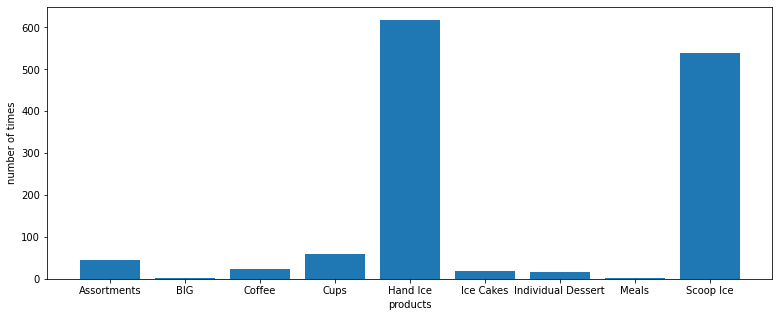

In [75]:
plt.figure(figsize=(13,5))
#y axis：counts
plt.bar(range(len(labs)),counts)
#change the name on the x axis 
plt.xticks(range(len(labs)),[encoder.classes_[lab] for lab in labs])
plt.xlabel('products')
plt.ylabel('number of times')
plt.show()

Similarly, create a barplot of the true outcomes. 

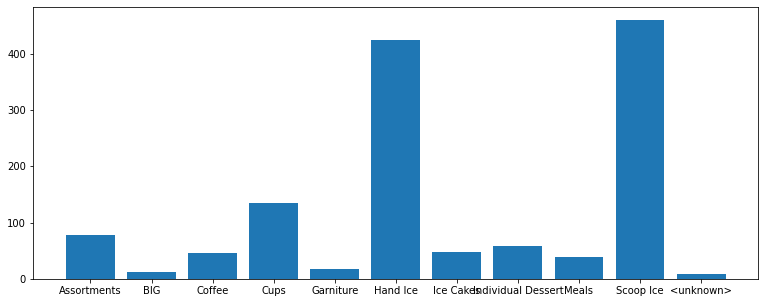

In [76]:
true_y,counts_y=np.unique(Y_val,return_counts=True)

plt.figure(figsize=(13,5))
#Y axis
plt.bar(range(len(true_y)),counts_y)
plt.xticks(range(len(true_y)),[encoder.classes_[i] for i in true_y])
plt.show()

## 6.2. KNN

K-Nearest Neighbours (KNN) is an algorithm that can be used for classification as well as regression problems. 

KNN is based on the idea that similar things are close to eachother. In other words, observations with the same outcome will be close to each other in terms of distance. 

(Remember that observations can be represented by vectors in space -> Hence, the distance between two observations can be calculated as the distance between the two vectors representing them)

The KNN algorithm goes as follows. For each new observation: 

    (1) Compute the distance between the new observation and all observations in the training set.
    (2) Take the K closest training observations, i.e. those with the smallest distance to the new observation. These are the K-nearest neighbours. 
    (3) Take the label (i.e., dependent variable or true outcome) of those training observations. 
    (4) The predicted outcome for the new observation is the mode (=the one that occurs the most) of the K true outcomes. 
   

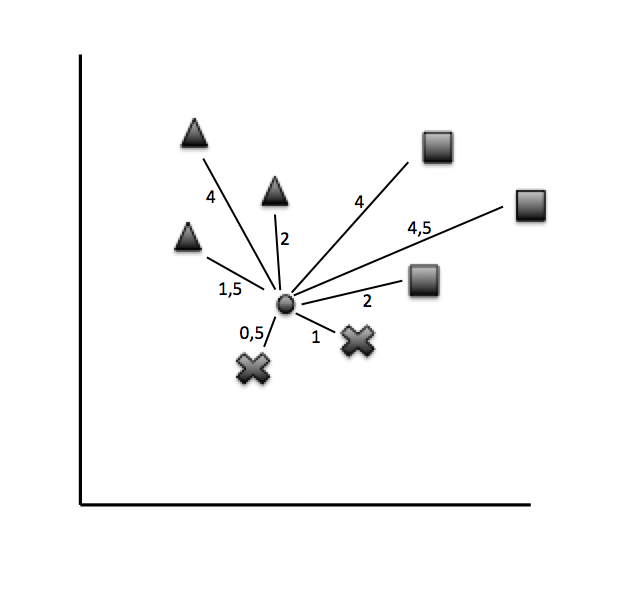

Create a predictive model using the KNN algorithm with K=20

In [77]:
X_train.head()

,RECENCY,FREQUENCY,TOTAL_AMOUNT,AVG_AMOUNT,Assortments,BIG,Coffee,Cups,Garniture,Hand Ice,...,LAST_FAMILY_BIG,LAST_FAMILY_Coffee,LAST_FAMILY_Cups,LAST_FAMILY_Garniture,LAST_FAMILY_Hand Ice,LAST_FAMILY_Ice Cakes,LAST_FAMILY_Individual Dessert,LAST_FAMILY_Meals,LAST_FAMILY_POS inside,LAST_FAMILY_Scoop Ice
6106,0.868996,0.020408,0.002055,0.016482,0,0,1,0,0,2,...,0,0,0,0,1,0,0,0,0,0
3385,0.128093,0.081633,0.004356,0.011204,0,0,0,3,0,2,...,0,0,0,0,0,0,0,0,0,1
600,0.247453,0.091837,0.012202,0.029667,0,0,4,0,0,2,...,0,0,0,0,1,0,0,0,0,0
1287,0.011645,0.326531,0.041419,0.030470,6,1,1,37,4,9,...,0,0,0,0,1,0,0,0,0,0
2631,0.197962,0.051020,0.005010,0.020073,1,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


In [78]:
knn=KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']],Y_train)
#get prediction:
knn_pred=knn.predict(X_val[['RECENCY','FREQUENCY','TOTAL_AMOUNT','AVG_AMOUNT']])
knn_pred

array([9, 5, 9, ..., 5, 5, 5])

Compute the accuracy of the predictive model 

In [79]:
# get accuracy
knn_val_acc = accuracy_score(Y_val, knn_pred)
# check
print("KNN val accuracy: %s %%" %(knn_val_acc * 100))

KNN val accuracy: 35.094339622641506 %


## 6.3. Random

Compute the predictions of a random model. This is our baseline model against which we can compare the other models. 

In [80]:
#get most bought product 
most_bought_product = np.unique(Y_train)[np.argmax(np.unique(Y_train, return_counts=True)[1])]
# make val predictions
random_val_preds = [most_bought_product for i in range(len(X_val))]

In [81]:
# get accuracy
random_val_acc = accuracy_score(Y_val, random_val_preds)
# check
print("random val accuracy: %s %%" %(random_val_acc * 100))

random val accuracy: 34.71698113207547 %


## 7. Model Evaluation

As a final step, create the final model and calculate its accuracy. 

In [82]:
# join train and val
train_big_X = pd.concat([X_train, X_val], axis=0)
train_big_y = np.concatenate([Y_train, Y_val], axis=0)

In [83]:
# define multinomial logistic regression model
mlr_model = LogisticRegression(max_iter=1000, multi_class="multinomial", solver="lbfgs")
# fit model on training set
mlr_model.fit(train_big_X, train_big_y)
# make predictions on test set
mlr_test_preds = mlr_model.predict(X_test)

In [84]:
# get accuracy
mlr_test_acc = accuracy_score(Y_test, mlr_test_preds)
# check
print("multilogit val accuracy: %s" %(mlr_test_acc * 100))

multilogit val accuracy: 51.62264150943396


Create a barplot of the predicted outcomes.

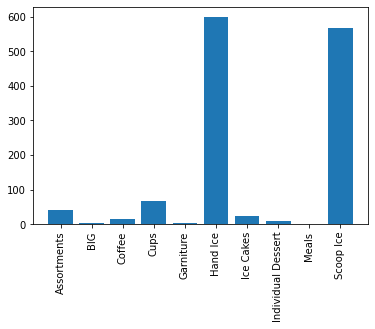

In [86]:
# get predicted labels and counts
labs, counts = np.unique(mlr_test_preds, return_counts=True)
plt.bar(range(len(labs)), counts)
plt.xticks(range(len(labs)), [encoder.classes_[lab] for lab in labs], rotation=90)
plt.show()